In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
ls "/content/drive/MyDrive/Colab Notebooks/door detection "

train/  train./  val/  val./


In [ ]:
ls "/content/drive/MyDrive/Colab Notebooks/door detection /val"

closed/  open/


In [ ]:
ls "/content/drive/MyDrive/Colab Notebooks/door detection /train/closed"

door0000001.png  door0000178.png  door0000405.png  door0000526.png
door0000002.png  door0000179.png  door0000406.png  door0000527.png
door0000003.png  door0000180.png  door0000407.png  door0000528.png
door0000004.png  door0000181.png  door0000409.png  door0000529.png
door0000005.png  door0000182.png  door0000410.png  door0000530.png
door0000006.png  door0000184.png  door0000411.png  door0000531.png
door0000007.png  door0000185.png  door0000412.png  door0000532.png
door0000008.png  door0000186.png  door0000413.png  door0000533.png
door0000009.png  door0000187.png  door0000414.png  door0000534.png
door0000010.png  door0000188.png  door0000417.png  door0000535.png
door0000011.png  door0000189.png  door0000418.png  door0000536.png
door0000024.png  door0000190.png  door0000419.png  door0000537.png
door0000025.png  door0000191.png  door0000420.png  door0000538.png
door0000026.png  door0000192.png  door0000421.png  door0000539.png
door0000027.png  door0000193.png  door0000422.png  door0000540

!unzip -uq "/content/drive/My Drive/RGB-2021315T172951Z-001" -d "/content/drive/My Drive/PATH_TO_OUTPUT"



In [ ]:
import os

num_skipped = 0
for folder_name in ("closed", "open"):
    folder_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/door detection /val", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            
             # os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 40 images


# Nouvelle section

In [ ]:
!mkdir my project


mkdir: cannot create directory ‘my’: File exists
mkdir: cannot create directory ‘project’: File exists


In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/door detection ",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/door detection ",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 470 files belonging to 4 classes.
Using 376 files for training.
Found 470 files belonging to 4 classes.
Using 94 files for validation.


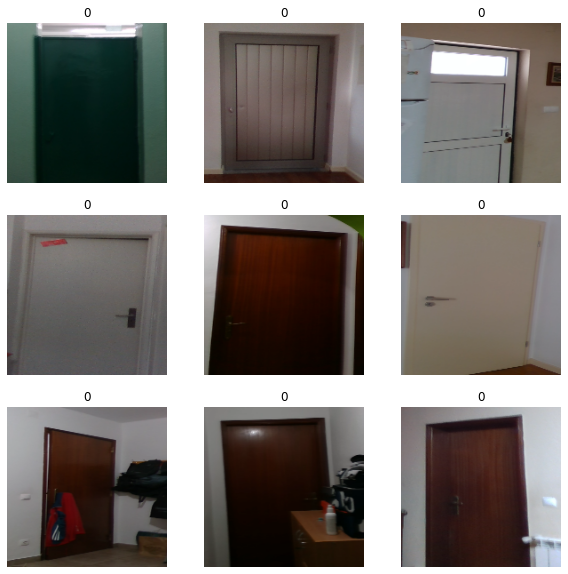

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

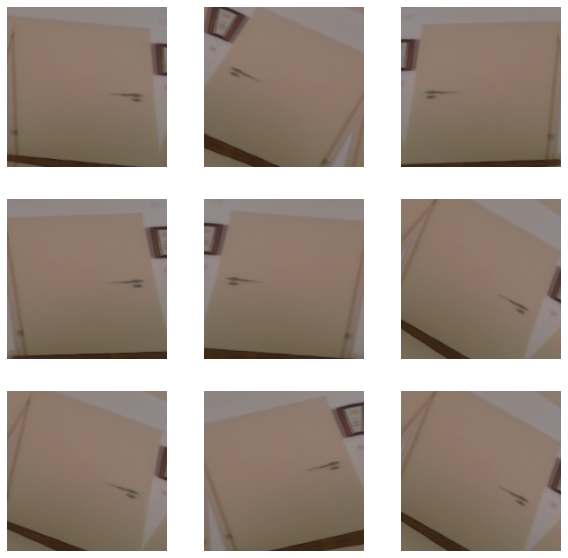

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
input_shape = (32, 32, 3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)

In [ ]:
rain_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

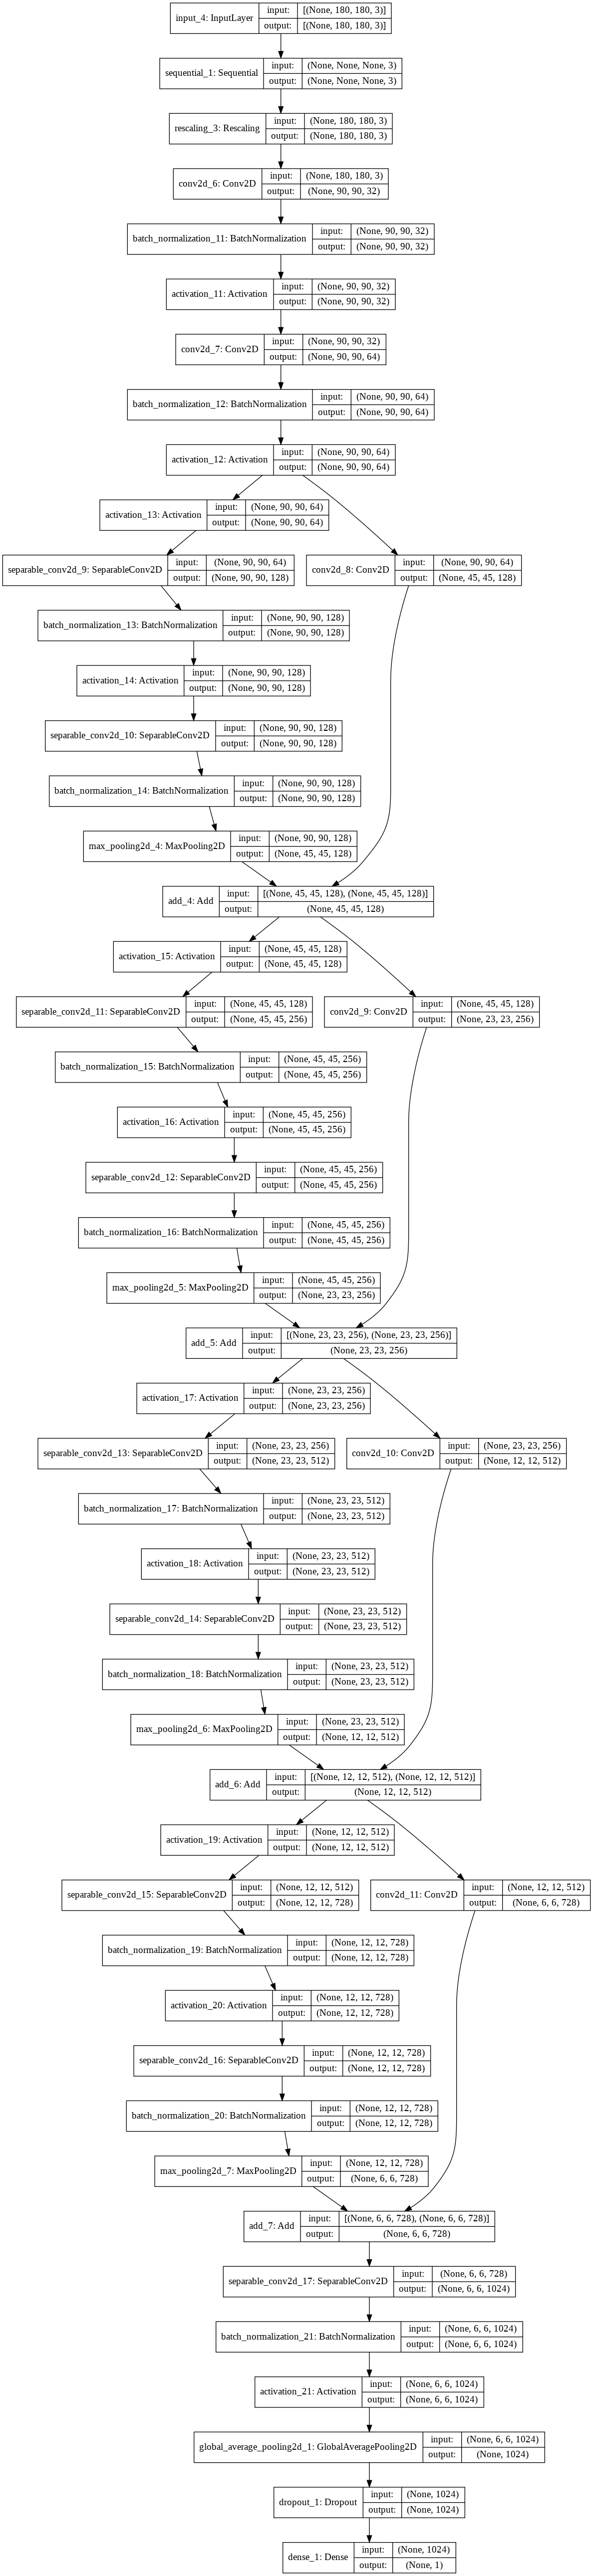

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 100

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
12/12 [==============================] - 12s 596ms/step - loss: 0.6324 - accuracy: 0.7479 - val_loss: 0.6607 - val_accuracy: 0.8511
Epoch 2/100
12/12 [==============================] - 6s 337ms/step - loss: 0.4307 - accuracy: 0.9114 - val_loss: 0.6534 - val_accuracy: 0.8511
Epoch 3/100
12/12 [==============================] - 6s 338ms/step - loss: 0.4208 - accuracy: 0.9034 - val_loss: 0.6540 - val_accuracy: 0.8511
Epoch 4/100
12/12 [==============================] - 6s 338ms/step - loss: 0.4688 - accuracy: 0.8845 - val_loss: 0.6450 - val_accuracy: 0.8511
Epoch 5/100
12/12 [==============================] - 6s 343ms/step - loss: 0.3187 - accuracy: 0.8811 - val_loss: 0.6361 - val_accuracy: 0.8511
Epoch 6/100
12/12 [==============================] - 6s 339ms/step - loss: 0.2882 - accuracy: 0.8967 - val_loss: 0.6250 - val_accuracy: 0.8511
Epoch 7/100
12/12 [==============================] - 6s 340ms/step - loss: 0.3152 - accuracy: 0.9224 - val_loss: 0.6220 - val_accuracy: 0.851

In [ ]:
model.save("my_model.h5")

In [ ]:
import cv2
import tensorflow as tf

CATEGORIES = ["closed", "open"]  


def prepare(filepath):
    IMG_SIZE = 70  
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
model = tf.keras.models.load_model("my_model.h5")

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 180, 180, 3)  0           sequential_1[0][0]               
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 90, 90, 32)   896         rescaling_3[0][0]                
____________________________________________________________________________________________

In [ ]:
tf.keras.metrics.Accuracy(
    name='accuracy', dtype=float
)

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/door/images.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent open and %.2f percent closed."
    % (100 * (1 - score), 100 * score)
)

This image is 99.99 percent open and 0.01 percent closed.


In [ ]:
import tensorflow as tf
from tensorflow import keras  
image_size = (180, 180)
img = keras.preprocessing.image.load_img("/content/drive/MyDrive/Colab Notebooks/download.png", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent open and %.2f percent closed."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent open and 100.00 percent closed.


In [ ]:
import tensorflow as tf
from tensorflow import keras  
image_size = (180, 180)
img = keras.preprocessing.image.load_img("/content/drive/MyDrive/door/download.jpg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent open and %.2f percent closed."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent open and 100.00 percent closed.
